In [0]:
!pip install gym > /dev/null 2>&1

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (45.2.0)


In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')

In [0]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path

import random, os.path, math, glob, csv, base64, itertools, sys
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import io
from IPython.display import HTML

from copy import deepcopy

# Discretization of the state space

In [0]:
from discretization import Discretizer

class DiscretizedMountainCar(gym.Wrapper):
    def __init__(self, n_bins):
        env_id = 'MountainCar-v0' 
        env = gym.make(env_id)
        self.env = env
        super().__init__(env)
        self.min_reward = -1.0
        self.max_reward = 0.0

        LM = env.observation_space.low
        HM = env.observation_space.high
        D = len(HM)

        bins = []
        for i in range(D):
            V = np.linspace(LM[i], HM[i], n_bins)
            bins.append(V[1:-1])
        self.grid = Discretizer(bins=bins)

        # Number of states
        self.S = self.grid.n_bins()
        # Number of actions
        self.A = self.env.action_space.n

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        reward = (reward - self.min_reward) / (self.max_reward - self.min_reward)
        if done:
            next_state = self.env.reset()
            reward = 1.0
        done = False 
        next_state = self.grid.dpos(next_state)
        return next_state, reward, done, info

    def reset(self):
        state = self.env.reset()
        state = self.grid.dpos(state)
        return state

# Environment
n_bins = 10
env = DiscretizedMountainCar(n_bins)

# Horizon
H = 180

# Backward induction (aka Value Iteration)

In [0]:
def backward_induction(P, R, H):
    """
        Parameters:
            P: transition function (S,A,S)-dim matrix
            R: reward function (S,A)-dim matrix
            H: horizon

        Returns:
            The optimal V-function: array of shape (horizon, S)
            The optimal policy
        
        V[h, s]
    """
    S, A = P.shape[0], P.shape[1]
    policy = np.zeros((H, S), dtype=np.int)
    V = np.zeros((H + 1, S))
    for h in reversed(range(H)):
        for s in range(S):
            """ 
            Here, we compute V^*(h, s) using the Bellman optimality equation:

            V[h, s] = max_a  R[s, a] + sum_{s'} P[s, a, s']*V[h+1, s']
            """
            for a in range(A):
                tmp = R[s, a] + np.dot(P[s, a],  V[h + 1])
                if (a == 0) or (tmp > V[h, s]):
                    policy[h, s] = a
                    V[h, s] = tmp
    return V, policy

Compute solution

## UCBVI (UCRL with exploration bonus)

In [0]:
def UCRL(mdp, H, nb_episodes, VSTAR=0, scale_factor = .5):
    S, A = mdp.S, mdp.A
    policy = np.zeros((H, S), dtype=np.int)
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sas = np.zeros((S,A,S), dtype=np.int)
    N_sa = np.zeros((S,A), dtype=np.int)
    episode_rewards = np.zeros((nb_episodes,))
  
    V = H*np.ones((H + 1, S))
    V[H, :] = 0

    S_sa = np.zeros((S,A)) 
    for k in range(nb_episodes):
        sum_rewards = 0
        # run optimistic value iteration
        V.fill(0)
        for h in reversed(range(H)):
            for s in range(S):
                temp = np.zeros(A)
                for a in range(A):
                    nn = N_sa[s, a] + 1
                    bonus = scale_factor*np.sqrt(1.0/nn)
                    temp[a] = Rhat[s, a] + Phat[s, a].dot(V[h + 1]) + bonus

                V[h, s] = min(H-h, temp.max())
                policy[h, s] = temp.argmax()
        # execute policy
        initial_state = state = mdp.reset()
        for h in range(H):
            action = policy[h][state]
            next_state, reward, done, _ = mdp.step(action)

            sum_rewards += reward
            
            # update estimates (Phat, Rhat, N_sa, N_sas)
            N_sa[state, action] += 1
            N_sas[state, action, next_state] +=1
            S_sa[state, action] += reward
            
            Rhat[state, action] = S_sa[state, action]/N_sa[state, action]
            Phat[state, action, :] = N_sas[state, action, :]/N_sa[state, action]

            
            state = next_state
        
        # update regret
        episode_rewards[k] = sum_rewards
        
        if k % 5 == 0 or k==1:
            print("rewards[{}]: {}".format(k, episode_rewards[k]), end = ", ")
            print("Number of visited states: ", (N_sa.sum(axis=1) > 0).sum() )
            # print(V[0, :])

    return episode_rewards, N_sa, Rhat, Phat, policy

In [0]:
nb_repetitions = 1
nb_episodes = 500
rewards = np.zeros((nb_repetitions, nb_episodes))
for it in range(nb_repetitions):
    print("Running simulation: {}".format(it))
    rewards[it], N_sa, Rhat, Phat, policy = UCRL(mdp=env, H=H, nb_episodes=nb_episodes)

Running simulation: 0
rewards[0]: 0.0, Number of visited states:  8
rewards[1]: 0.0, Number of visited states:  9
rewards[5]: 0.0, Number of visited states:  25
rewards[10]: 0.0, Number of visited states:  45
rewards[15]: 0.0, Number of visited states:  50
rewards[20]: 0.0, Number of visited states:  53
rewards[25]: 0.0, Number of visited states:  57
rewards[30]: 1.0, Number of visited states:  59
rewards[35]: 0.0, Number of visited states:  59
rewards[40]: 1.0, Number of visited states:  59
rewards[45]: 0.0, Number of visited states:  65
rewards[50]: 1.0, Number of visited states:  65
rewards[55]: 0.0, Number of visited states:  65
rewards[60]: 1.0, Number of visited states:  66
rewards[65]: 0.0, Number of visited states:  66
rewards[70]: 1.0, Number of visited states:  66
rewards[75]: 0.0, Number of visited states:  67
rewards[80]: 1.0, Number of visited states:  67
rewards[85]: 0.0, Number of visited states:  68
rewards[90]: 0.0, Number of visited states:  68
rewards[95]: 0.0, Numbe

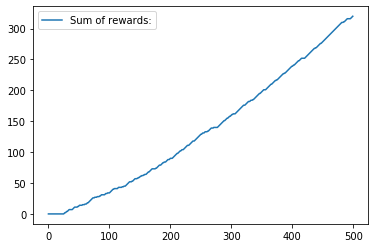

In [0]:
plt.plot(np.cumsum(rewards), label="Sum of rewards:")
plt.legend()

In [0]:
# The following code is will be used to visualize the environments.
def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)
  
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

state = env.reset()
for hh in range(H): 
    action = policy[hh, state]
    state, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!
